### Active Learning for Predicting Voigt-Reuss-Hill Bulk Modulus

In [2]:
# import python libraries (rerun cell if get a 'duecredit' error)
from mp_api.client import MPRester
import pandas as pd
import numpy as np
from flatten_dict import flatten
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import norm
import forestci as fci
import warnings

#suppress warnings from fci
warnings.filterwarnings('ignore')

# function to determine the expected improvement
def expI(y_post,sigma_post,y_best,epsilon,scale,loc):
    EI = np.empty(y_post.size,dtype=float)
    for i in range(0,y_post.size):
        if sigma_post[i] > 1e-3: # values where sigma is 0 or very small will give errors
            zz = (y_post[i]-y_best-epsilon)/sigma_post[i]
            EI[i] = (y_post[i]-y_best-epsilon)*norm.cdf(zz,scale=scale,loc=loc)+sigma_post[i]*norm.pdf(zz,scale=scale,loc=loc)
        else:
            EI[i] = 0.0
    return EI

In [4]:
# retrieve data from MP on all stable compounds (~2 min)
with MPRester('MP API CODE') as mpr: # << ADD MPI API code here!!!
    docs = mpr.summary.search(
                              is_stable = [True],                    
                              fields = ['material_id','elements','composition_reduced',
                                        'formula_pretty','band_gap','structure','k_vrh','g_vrh'
                                       ]
                             )

# flatten dictionary
flattened = [{
    k: v for k, v in flatten(doc.dict(), reducer="dot").items() if k != "fields_not_requested"
} for doc in docs]

# reformat data into a dataframe object
df = pd.DataFrame.from_records(flattened)
    
# drop elemental He, Ne, Ar
df = df.drop(df[df['composition_reduced.He']>0].index)
df = df.drop(df[df['composition_reduced.Ne']>0].index)
df = df.drop(df[df['composition_reduced.Ar']>0].index)

# drop compounds that do not have bulk modulus data
df = df.dropna(subset='k_vrh')

Retrieving SummaryDoc documents:   0%|          | 0/35463 [00:00<?, ?it/s]

Featurize the data

In [5]:
# define MagPie featurization (~5 min)
featurizer = ElementProperty.from_preset('magpie')
str_comp = StrToComposition(target_col_id='pmg_comp')

# featurize data set
df = str_comp.featurize_dataframe(df,col_id='formula_pretty')
features = featurizer.featurize_dataframe(df,col_id='pmg_comp')

StrToComposition:   0%|          | 0/3937 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3937 [00:00<?, ?it/s]

In [8]:
# remove the unneeded columns from the feature dataframe
features = features[features.columns[97:]]

# reindex the data and feature dataframes
df = df.reset_index(drop=True)
features = features.reset_index(drop=True)

# uncomment to save dataframes as Microsoft Excel xlsx files to import in the future
#features.to_excel('Kvrh_features.xlsx',index=False)
#df.to_excel('Kvrh.xlsx',index=False)

In [3]:
# uncomment to load feature and data dataframes from Excel files
#features = pd.read_excel('Kvrh_features.xlsx')
#df = pd.read_excel('Kvrh.xlsx')

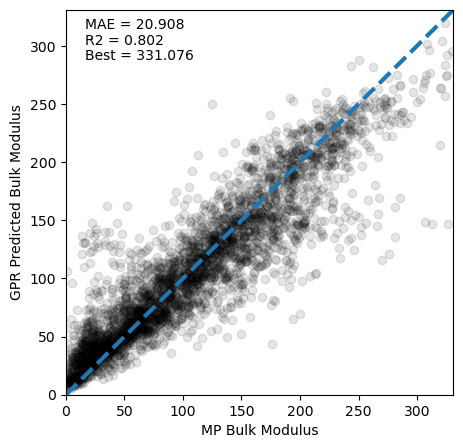

In [14]:
# test the prediction quality of a RFR model
n_samp = 400      # number of initial known samples
rfr = RandomForestRegressor(n_estimators=100) # define parameters of Random Forest Regression model
np.random.seed(2) # random seed for reproducible results
mae = []         # initialize list for MAE
r2 = []           # initialize list for R2

# create an initial training dataset with n_samp random samples
df_train_rfr = df.sample(n_samp).copy()
df_remain_rfr = df.drop(df_train_rfr.index).copy()
features_train_rfr = features.iloc[df_train_rfr.index].copy()
features_remain_rfr = features.drop(df_train_rfr.index).copy()

# fit the RFR model
rfr.fit(features_train_rfr,df_train_rfr['k_vrh'])
y_pred_rfr = rfr.predict(features_remain_rfr)
sigma_pred_rfr = fci.random_forest_error(rfr,np.array(features_train_rfr),np.array(features_remain_rfr))

# create the parity plot for the final iteration
mae.append(mean_absolute_error(df_remain_rfr['k_vrh'],y_pred_rfr))
r2.append(r2_score(df_remain_rfr['k_vrh'],y_pred_rfr))
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(df_remain_rfr['k_vrh'],y_pred_rfr,alpha=0.1,color='k',
#            s=sigma_pred_rfr
           )
plt.plot([0,y_pred_rfr.max()],[0,y_pred_rfr.max()],linestyle='--',lw=3)
plt.xlim(0,y_pred_rfr.max())
plt.ylim(0,y_pred_rfr.max())
plt.xlabel('MP Bulk Modulus')
plt.ylabel('GPR Predicted Bulk Modulus')
plt.text(x=.05,y=.95,s=f'MAE = {round(mae[-1],3)}',transform=ax.transAxes)
plt.text(x=.05,y=.91,s=f'R2 = {round(r2[-1],3)}',transform=ax.transAxes)
plt.text(x=.05,y=.87,s=f'Best = {round(y_pred_rfr.max(),3)}',transform=ax.transAxes)
plt.show()

Training size: 400 , Prediction size: 3537
Training size: 450 , Prediction size: 3487
Training size: 500 , Prediction size: 3437
Training size: 550 , Prediction size: 3387
Training size: 600 , Prediction size: 3337
Training size: 650 , Prediction size: 3287
Training size: 700 , Prediction size: 3237
Training size: 750 , Prediction size: 3187
Training size: 800 , Prediction size: 3137
Training size: 850 , Prediction size: 3087


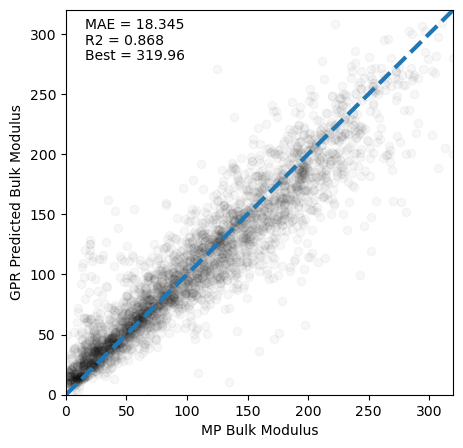

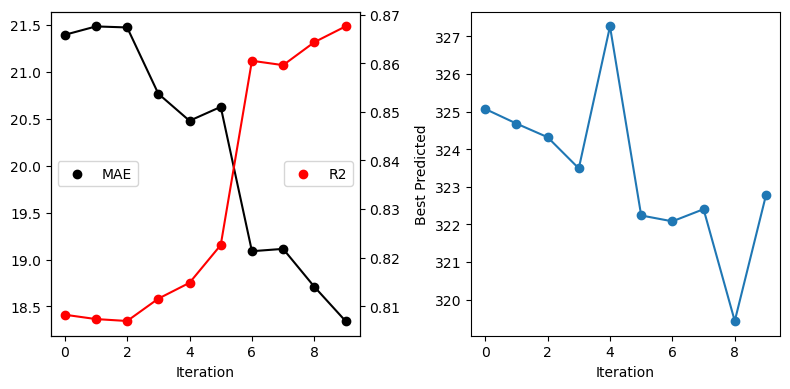

In [25]:
# iteratively train a model to predict k_vrh with active learning
n_samp = 400      # number of initial known samples
n_loops = 10       # number of active learning iterations (1 loop means no added compounds)
n_compounds = 50  # number of new compounds to measure in each iteration
epsilon = 0       # exploration/exploitation parameter (increase to favor exploration)
rfr = RandomForestRegressor(n_estimators=100) # define parameters of Random Forest Regression model
np.random.seed(8) # random seed for reproducible results
mae = []         # initialize list for MAE
r2 = []           # initialize list for R2
y_best_list = []  # initialize list for Best prediction
plot_EI = False    # turn on plotting of best EI compounds

# create an initial training dataset with n_samp random samples
df_train_rfr = df.sample(n_samp).copy()
df_remain_rfr = df.drop(df_train_rfr.index).copy()
features_train_rfr = features.iloc[df_train_rfr.index].copy()
features_remain_rfr = features.drop(df_train_rfr.index).copy()

for loop in range(n_loops):
    # print the number of data points in the training/prediction sets
    print('Training size:',len(features_train_rfr),', Prediction size:',len(features_remain_rfr))
    
    # fit the RFR model
    rfr.fit(features_train_rfr,df_train_rfr['k_vrh'])
    y_pred_rfr = rfr.predict(features_remain_rfr)
    sigma_pred_rfr = fci.random_forest_error(rfr,np.array(features_train_rfr),np.array(features_remain_rfr))

    # determine the maximum predicted k_vrh in the training set
    y_best = rfr.predict(features_train_rfr).max()

    # determine the set of zz (to be able to scale and locate distribution for CDF/PDF)
    zz = (y_pred_rfr-y_best)/sigma_pred_rfr

    # calculate Expected Improvement
    EI = expI(y_pred_rfr,sigma_pred_rfr,y_best,epsilon,scale=zz.std(),loc=zz.mean())

    # plot EI
    EI_df = pd.DataFrame(EI,columns=['EI'])
    EI_df_top = EI_df.sort_values(by='EI',ascending=False).head(n_compounds)
    if plot_EI == True:
        plt.figure(figsize=(6,3))
        plt.scatter(range(len(EI)),EI,alpha=0.03,color='k')
        plt.scatter(EI_df_top.index,EI_df_top,color='r',facecolors='none')
        plt.xlabel('Sample Number')
        plt.ylabel('Expected Improvement')
        comp_names = df_remain_rfr.iloc[EI_df_top.index]['formula_pretty']
        for i, comp in enumerate(comp_names):
            plt.annotate(comp,(EI_df_top.index[i],float(EI_df_top['EI'].loc[EI_df_top.index[i]])))
        plt.show()
    
    # create the parity plot for the final iteration
    mae.append(mean_absolute_error(df_remain_rfr['k_vrh'],y_pred_rfr))
    r2.append(r2_score(df_remain_rfr['k_vrh'],y_pred_rfr))
    y_best_list.append(y_best)
    if loop == n_loops-1: # only print the parity plot for the final iteration
        fig,ax = plt.subplots(figsize=(5,5))
        plt.scatter(df_remain_rfr['k_vrh'],y_pred_rfr,alpha=0.1,color='k')
                    #,s=sigma_pred_rfr)
        plt.plot([0,y_pred_rfr.max()],[0,y_pred_rfr.max()],linestyle='--',lw=3)
        plt.xlim(0,y_pred_rfr.max())
        plt.ylim(0,y_pred_rfr.max())
        plt.xlabel('MP Bulk Modulus')
        plt.ylabel('GPR Predicted Bulk Modulus')
        plt.text(x=.05,y=.95,s=f'MAE = {round(mae[-1],3)}',transform=ax.transAxes)
        plt.text(x=.05,y=.91,s=f'R2 = {round(r2[-1],3)}',transform=ax.transAxes)
        plt.text(x=.05,y=.87,s=f'Best = {round(y_pred_rfr.max(),3)}',transform=ax.transAxes)
        plt.show()

    # add top {n_compounds} compounds to training dataset, remove them from the remain dataset
    features_train_rfr = pd.concat([features_train_rfr,features_remain_rfr.iloc[EI_df.sort_values(by='EI',ascending=False).head(n_compounds).index]])
    features_remain_rfr = features_remain_rfr.drop(features_remain_rfr.iloc[EI_df.sort_values(by='EI',ascending=False).head(n_compounds).index].index)
    df_train_rfr = pd.concat([df_train_rfr,df_remain_rfr.iloc[EI_df.sort_values(by='EI',ascending=False).head(n_compounds).index]])
    df_remain_rfr = df_remain_rfr.drop(df_remain_rfr.iloc[EI_df.sort_values(by='EI',ascending=False).head(n_compounds).index].index)

# print plots of the trends in MAE, R2, and Best predicted sample over iterations
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(range(len(mae)),mae,color = 'k',label='MAE')
ax[0].plot(mae,color='k')
ax[0].legend(loc='center left')
ax1 = plt.twinx(ax=ax[0])
ax1.scatter(range(len(r2)),r2,color='r',label='R2')
ax1.plot(r2,color='r')
ax1.legend(loc='center right')
ax[0].set_xlabel('Iteration')
ax[1].plot(y_best_list)
ax[1].scatter(range(len(y_best_list)),y_best_list)
ax[1].set_ylabel('Best Predicted')
ax[1].set_xlabel('Iteration')
plt.tight_layout()

Training size: 400 , Prediction size: 3537
Training size: 450 , Prediction size: 3487
Training size: 500 , Prediction size: 3437
Training size: 550 , Prediction size: 3387
Training size: 600 , Prediction size: 3337
Training size: 650 , Prediction size: 3287
Training size: 700 , Prediction size: 3237
Training size: 750 , Prediction size: 3187
Training size: 800 , Prediction size: 3137
Training size: 850 , Prediction size: 3087


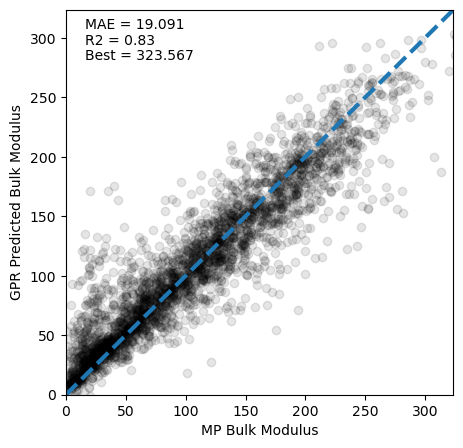

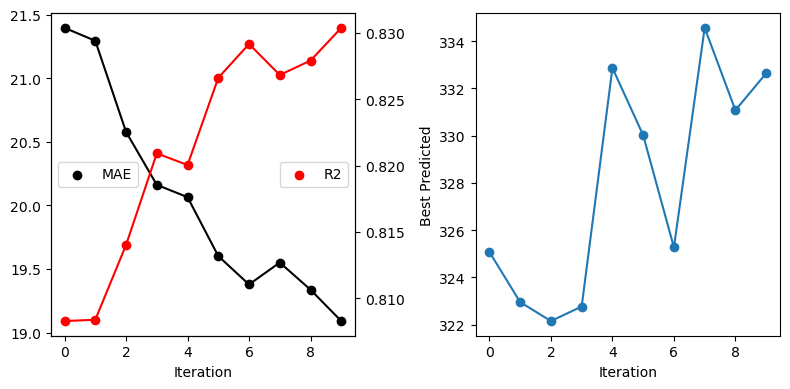

In [26]:
# compare our active learning approach to a random sampling approach
n_samp = 400      # number of initial known samples
n_loops = 10       # number of active learning iterations (1 loop means no added compounds)
n_compounds = 50  # number of new compounds to measure in each iteration
rfr = RandomForestRegressor(n_estimators=100) # define parameters of Random Forest Regression model
np.random.seed(8) # random seed for reproducible results
mae = []         # initialize list for MAE
r2 = []           # initialize list for R2
y_best_list = []  # initialize list for Best prediction

# create an initial training dataset with n_samp random samples
df_train_rfr = df.sample(n_samp).copy()
df_remain_rfr = df.drop(df_train_rfr.index).copy()
features_train_rfr = features.iloc[df_train_rfr.index].copy()
features_remain_rfr = features.drop(df_train_rfr.index).copy()

for loop in range(n_loops):
    # print the number of data points in the training/prediction sets
    print('Training size:',len(features_train_rfr),', Prediction size:',len(features_remain_rfr))
    
    # fit the RFR model
    rfr.fit(features_train_rfr,df_train_rfr['k_vrh'])
    y_pred_rfr = rfr.predict(features_remain_rfr)
    sigma_pred_rfr = fci.random_forest_error(rfr,np.array(features_train_rfr),np.array(features_remain_rfr))

    # determine the maximum predicted k_vrh in the training set
    y_best = rfr.predict(features_train_rfr).max()
    
    # create the parity plot for the final iteration
    mae.append(mean_absolute_error(df_remain_rfr['k_vrh'],y_pred_rfr))
    r2.append(r2_score(df_remain_rfr['k_vrh'],y_pred_rfr))
    y_best_list.append(y_best)
    if loop == n_loops-1: # only print the parity plot for the final iteration
        fig,ax = plt.subplots(figsize=(5,5))
        plt.scatter(df_remain_rfr['k_vrh'],y_pred_rfr,alpha=0.1,color='k')
                    #,s=sigma_pred_rfr)
        plt.plot([0,y_pred_rfr.max()],[0,y_pred_rfr.max()],linestyle='--',lw=3)
        plt.xlim(0,y_pred_rfr.max())
        plt.ylim(0,y_pred_rfr.max())
        plt.xlabel('MP Bulk Modulus')
        plt.ylabel('GPR Predicted Bulk Modulus')
        plt.text(x=.05,y=.95,s=f'MAE = {round(mae[-1],3)}',transform=ax.transAxes)
        plt.text(x=.05,y=.91,s=f'R2 = {round(r2[-1],3)}',transform=ax.transAxes)
        plt.text(x=.05,y=.87,s=f'Best = {round(y_pred_rfr.max(),3)}',transform=ax.transAxes)
        plt.show()

    # add top {n_compounds} compounds to training dataset, remove them from the remain dataset
    new_features = features_remain_rfr.sample(n_compounds)
    features_remain_rfr = features_remain_rfr.drop(new_features.index)
    features_train_rfr = pd.concat([features_train_rfr,new_features])
    df_train_rfr = pd.concat([df_train_rfr,df_remain_rfr.loc[new_features.index]])
    df_remain_rfr = df_remain_rfr.drop(new_features.index)

# print plots of the trends in MAE, R2, and Best predicted sample over iterations
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(range(len(mae)),mae,color = 'k',label='MAE')
ax[0].plot(mae,color='k')
ax[0].legend(loc='center left')
ax1 = plt.twinx(ax=ax[0])
ax1.scatter(range(len(r2)),r2,color='r',label='R2')
ax1.plot(r2,color='r')
ax1.legend(loc='center right')
ax[0].set_xlabel('Iteration')
ax[1].plot(y_best_list)
ax[1].scatter(range(len(y_best_list)),y_best_list)
ax[1].set_ylabel('Best Predicted')
ax[1].set_xlabel('Iteration')
plt.tight_layout()